In [20]:
#Setup
from qiskit import QuantumCircuit
from dotenv import load_dotenv
import os
from qiskit_aer import AerSimulator
from qiskit_ibm_provider import IBMProvider
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.visualization import plot_histogram
import numpy as np

load_dotenv()
key = os.getenv("IMBQ_KEY")
provider = IBMProvider()

Exercise 4 -> Deutsch-Jozsa : Create our first quantum algorithm

Select the way to execute the circuit
- 'REAL' for a real quantum computer
- 'SIMULATED' for a simulated quantum computer
- 'LOCAL' for a Aer simulator (local simulated quantum computer)

In [21]:
def select_backend(token, backend='REAL'):
    backend_computer = None
    if backend == 'REAL':
        service = QiskitRuntimeService(channel="ibm_quantum", token=token)
        backend_computer = service.least_busy(simulator=False, operational=True)
    elif backend == 'SIMULATED':
        service = QiskitRuntimeService(channel="ibm_quantum", token=token)
        backend_computer = service.least_busy(simulator=True, operational=True)
    elif backend == 'LOCAL':
        backend_computer = AerSimulator()
    return backend_computer

make the given circuit (qc) usable on quantum computer (convert gates if it's required)

In [22]:
def optimize_circuit(qc, backend, op_level=0):
    pm = generate_preset_pass_manager(backend=backend, optimization_level=op_level)
    return pm.run(qc)

Balanced -> is an oracle type that can modify each qubit given in params

In [23]:
def balanced(nb_qbit=4): # code from subject creator
    qc = QuantumCircuit(nb_qbit, name='Balanced')
    b = np.random.randint(1,2**nb_qbit-1)
    b_str = format(b, '0'+str(nb_qbit-1)+'b')
    for qubit in range(len(b_str)):
        if b_str[qubit] == '1':
            qc.x(qubit)

    for qubit in range(nb_qbit-1):
        qc.cx(qubit, nb_qbit-1)
    for qubit in range(len(b_str)):
        if b_str[qubit] == '1':
            qc.x(qubit)
    
    return qc

Constant -> is an oracle type that only modify the last qubit given in param

In [24]:
def constant(nb_qbit=4): # code from subject creator
    qc = QuantumCircuit(nb_qbit, name='Constant')
    if np.random.randint(2) == 1:
        qc.x(nb_qbit-1)
    
    return qc

In [25]:
nb_qbit = 4

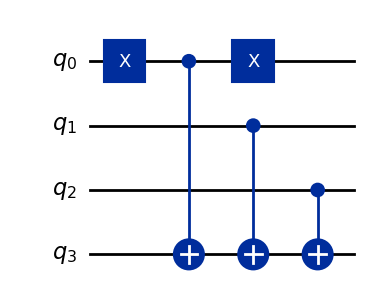

In [26]:
oracle1 = balanced(nb_qbit)
oracle1.to_gate()
oracle1.draw('mpl')

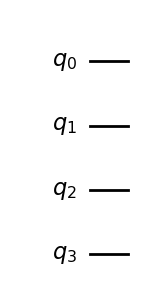

In [27]:
oracle2 = constant(nb_qbit)
oracle2.to_gate()
oracle2.draw('mpl')

Set up the main circuit with three principal parts
- the initialisation
- the oracle application
- the observation

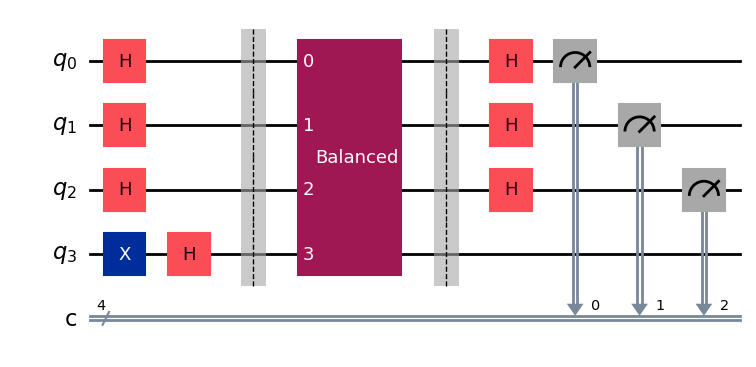

In [28]:
## initiate qubit
qc = QuantumCircuit(nb_qbit, nb_qbit)
qc.x(nb_qbit - 1)
for i in range(0, nb_qbit):
    qc.h(i)    
qc.barrier()

## apply oracle
qc.append(oracle1, range(nb_qbit))
qc.barrier()

## undo Hadamard gate
for i in range(0, nb_qbit - 1):
    qc.h(i)
    
## observe qubits values
for i in range(nb_qbit - 1):
    qc.measure(i, i)


qc.draw('mpl')

In [35]:
quantum_computer = select_backend(key, backend='LOCAL')

op_circuit = optimize_circuit(qc, quantum_computer, op_level=3)

result = quantum_computer.run(op_circuit, shots=500).result()
data = result.get_counts(op_circuit)

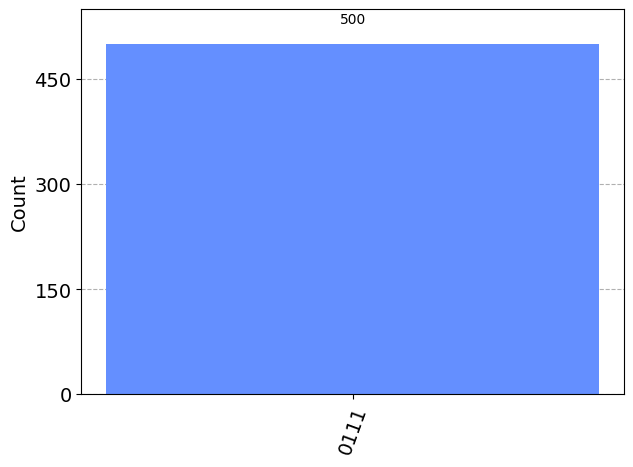

In [36]:
plot_histogram([data])